# Topic Modeling on Repository Artifacts

This notebook applies Latent Dirichlet Allocation (LDA) to your mined repository data (Commits & PRs) using your custom preprocessing pipeline.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess

# Setup Paths
BASE = Path("/Users/lukas./Desktop/CMPUT660Project/inputs/processed")

# Configuration
NUM_TOPICS = 5  # Number of topics to discover
PASSES = 10     # Training epochs (higher = better quality, slower)

## 1. Load Data
Loading commits and PR bodies, normalizing dates, and sorting chronologically.

In [2]:
def load_and_prep(filename):
    fpath = BASE / filename
    if not fpath.exists():
        return pd.DataFrame()
  
    df = pd.read_parquet(fpath)

    # Normalize Date
    date_col = 'date' if 'date' in df.columns else 'created_at'
    if date_col in df.columns:
        df['date'] = pd.to_datetime(df[date_col])
    
    # Normalize Text
    if 'text' in df.columns:
        df = df[['date', 'text']].dropna()
        # Tag the period based on filename
        if "before" in filename:
            df['period'] = 'Before'
        else:
            df['period'] = 'After'
        return df
    return pd.DataFrame()

# Load all relevant files
files = [
    "commit_messages_before.parquet", "commit_messages_after.parquet",
    "pr_bodies_before.parquet", "pr_bodies_after.parquet"
]

dfs = [load_and_prep(f) for f in files]
full_df = pd.concat(dfs)

# SORT BY DATE (Crucial for time-series plotting)
full_df = full_df.sort_values(by="date")

print(f"Loaded {len(full_df):,} documents.")
print(f"Date Range: {full_df['date'].min()} to {full_df['date'].max()}")

# Extract text as list
documents = full_df['text'].astype(str).tolist()
dates = full_df['date'].tolist()
periods = full_df['period'].tolist()  # Keep track of labels

Loaded 44,494 documents.
Date Range: 2010-09-12 09:08:11+00:00 to 2025-11-24 12:29:23+00:00


## 2. Preprocessing
Applying custom filters (stripping tags, punctuation, numeric) and removing stopwords.

In [3]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import preprocess_string # splitting 
from gensim.corpora.dictionary import Dictionary # build vocabular

# Initial stopword removal
processed_docs = [remove_stopwords(doc.lower()) for doc in documents]

CUSTOM_FILTERS = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]

tokenized = [preprocess_string(text, CUSTOM_FILTERS) for text in processed_docs]

# Stemming doesn't always help
stemmer = PorterStemmer()

def stem_document(p,doc):
    return [p.stem(word) for word in doc]

stemmed = [stem_document(stemmer,doc) for doc in tokenized]

for i in range(10):
    print(i, " ", stemmed[i])
    
# # disable stemming (Using your logic to overwrite)
stemmed = tokenized

0   ['genericfacil', 'collectknowledg']
1   ['import', 'maven', 'osgi', 'sourc', 'untouch', 'releas', 'jawk', 'januari', 'apart', 'rearrang', 'import', 'packag']
2   ['unifi', 'indent', 'us', 'tab', 'instead', 'mix', 'space', 'tab', 'indent', 'add', 'brace', 'singl', 'instruct', 'loop', 'condit', 'express', 'function', 'chang', 'work', 'netbean', 'auto', 'format', 'tool']
3   ['cleanup', 'fix', 'spell', 'error', 'comment', 'remov', 'superflu', 'final', 'modifi', 'method', 'ad', 'overrid', 'annot', 'replac', 'size', 'isempti']
4   ['fix', 'stuff', 'findbug', 'pmd', 'fix', 'style', 'perform', 'relev', 'bulkblockobject', 'assocarrai', 'fix', 'actual', 'logic', 'potenti', 'crash', 'bug']
5   ['rid', 'code', 'duplic', 'cpd', 'tool', 'pmd', 'plugin']
6   ['import', 'instead', 'fulli', 'qualifi', 'class', 'code']
7   ['checkstyl', 'fix', 'arrai', 'bracket', 'illeg', 'posit', 'ad', 'move', 's', 's', 'follow', 'preced', 'white', 'space']
8   ['cleanup', 'mostli', 'comment', 'log', 'messag', 'wh

## 3. Train LDA Model
Building the dictionary, filtering extremes, and training the model.

In [4]:
vocab = Dictionary( stemmed )
print(f"Initial vocab size: {len(vocab)}")

vocab.filter_extremes(no_below=2, no_above=0.5)
print(f"Filtered vocab size: {len(vocab)}")

corpus = [vocab.doc2bow(doc) for doc in stemmed]

ALPHA = 0.01
BETA = 0.01
PASSES = 10
TOPICS = 20

dumb_dictionary_bug = vocab[0]
id2word = vocab.id2token

print("Training LDA Model...")
lda = gensim.models.LdaModel(
    corpus,
    num_topics=TOPICS,
    id2word=id2word,
    passes=PASSES,
    alpha=ALPHA,
    eval_every=5,
    eta=BETA
)

# Print Topics
for idx, topic in lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

Initial vocab size: 32104
Filtered vocab size: 14713
Training LDA Model...
Topic: 0 
Words: 0.063*"v" + 0.054*"java" + 0.041*"fixes" + 0.040*"app" + 0.040*"d" + 0.036*"s" + 0.034*"x" + 0.032*"issue" + 0.031*"resolve" + 0.028*"compatibility"

Topic: 1 
Words: 0.068*"project" + 0.061*"logic" + 0.052*"adjust" + 0.042*"sdk" + 0.039*"directory" + 0.038*"array" + 0.035*"read" + 0.034*"exists" + 0.033*"txt" + 0.032*"source"

Topic: 2 
Words: 0.221*"update" + 0.067*"refactor" + 0.061*"use" + 0.051*"dependencies" + 0.048*"md" + 0.046*"services" + 0.046*"metadata" + 0.037*"repository" + 0.036*"path" + 0.034*"readme"

Topic: 3 
Words: 0.155*"tests" + 0.144*"test" + 0.069*"add" + 0.067*"to" + 0.050*"original" + 0.042*"coverage" + 0.039*"helper" + 0.038*"id" + 0.037*"output" + 0.027*"format"

Topic: 4 
Words: 0.125*"https" + 0.125*"com" + 0.118*"e" + 0.110*"testing" + 0.061*"test" + 0.059*"add" + 0.049*"fails" + 0.028*"new" + 0.027*"users" + 0.018*"module"

Topic: 5 
Words: 0.171*"summary" + 0.115*

## 4. Map Documents to Topics & Visualize
Here we convert the model output into a dense matrix and plot the topic trends over time.

In [5]:
# Initialize a matrix of shape (Num Topics, Num Documents)
# We transpose it so row=Topic, col=Time/Document
document_topics = np.zeros((TOPICS, len(corpus)))

for i, doc_bow in enumerate(corpus):
    topic_probs = lda.get_document_topics(doc_bow)
    for topic_id, prob in topic_probs:
        document_topics[topic_id, i] = prob

print("Document-Topic Matrix Shape:", document_topics.shape)

Document-Topic Matrix Shape: (20, 44494)


## 5. Visualizing Topics Over Time (Split by Period)
We split the timeline into 'Before' and 'After' periods based on your dataset tagging, then create separate stacked area charts for each period.

Split point found at index 14036 (2024-12-28 01:42:59+00:00)


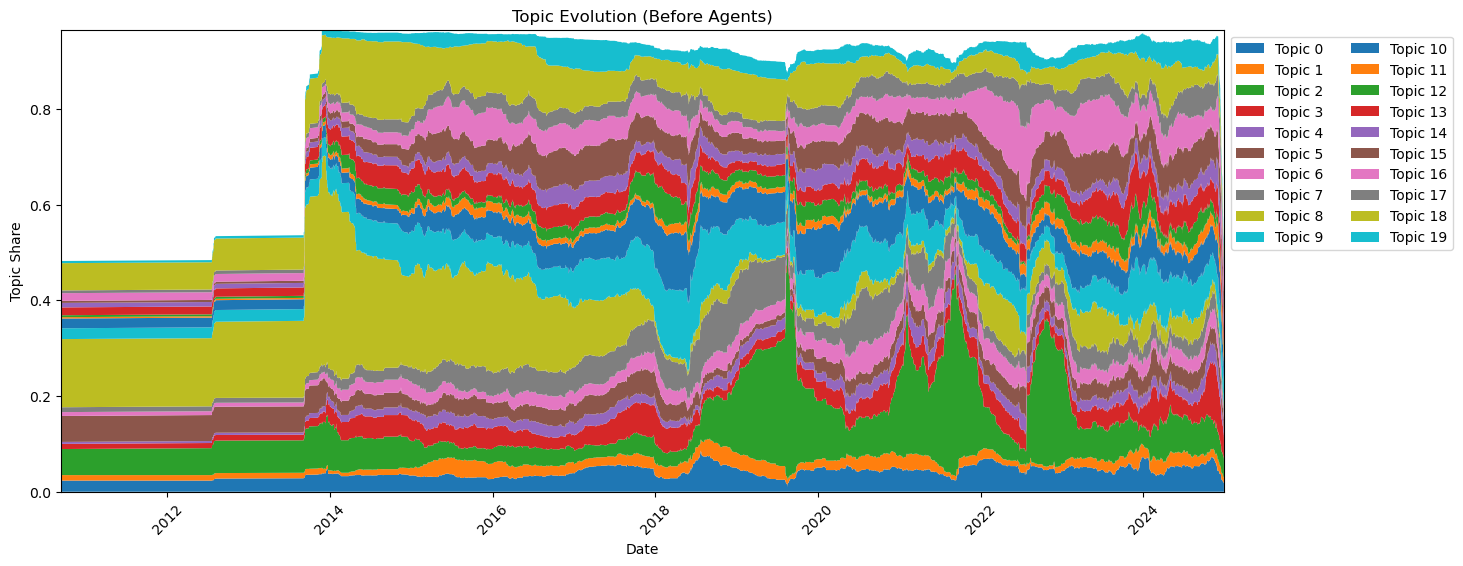

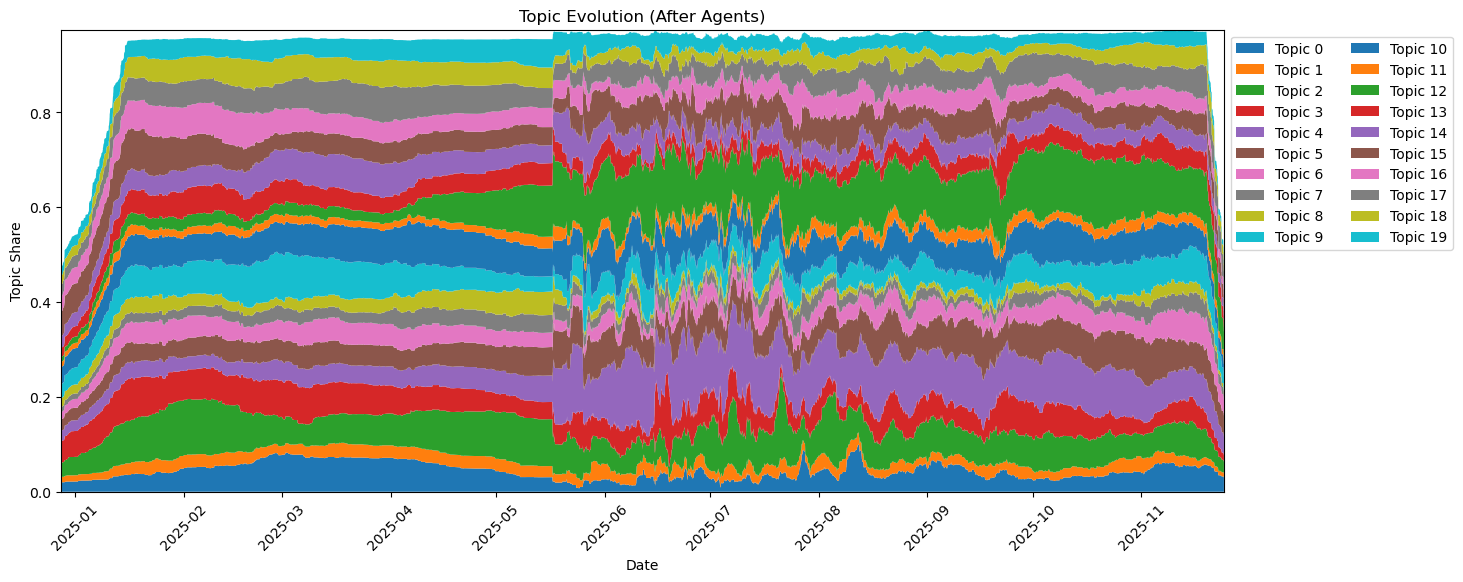

In [6]:
def moving_average(X, bins):
    # Pad to keep shape consistent
    pad_width = bins // 2
    return np.convolve(X, np.ones(bins)/bins, mode='same')

N = document_topics.shape[1]
WINDOW = 500  # Smoothing window (adjust based on data volume)

# 1. Find the split point
try:
    transition_idx = periods.index('After')
    print(f"Split point found at index {transition_idx} ({dates[transition_idx]})")
except ValueError:
    print("No 'After' period found. Plotting full range.")
    transition_idx = N

# 2. Slice the Data
dates_before = dates[:transition_idx]
dates_after = dates[transition_idx:]
topics_before = document_topics[:, :transition_idx]
topics_after = document_topics[:, transition_idx:]

# 3. Helper Function to Plot Stacked Area
def plot_stacked_topics(dates_subset, topics_subset, title):
    if len(dates_subset) == 0:
        print(f"No data for {title}")
        return

    # Calculate moving average for this subset
    # We re-calculate mavg here so it smooths within the period boundaries
    # Adjust window if subset is small
    local_window = min(WINDOW, len(dates_subset) // 5) if len(dates_subset) > 0 else 1
    local_window = max(local_window, 1) # ensure at least 1

    mavg = np.array([
        moving_average(topics_subset[i, :], local_window) for i in range(TOPICS)
    ])

    plt.figure(figsize=(15, 6))
    plt.stackplot(dates_subset, mavg, labels=[f"Topic {i}" for i in range(TOPICS)])
    
    # Legend
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2) 
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Topic Share")
    plt.margins(0,0)
    plt.xticks(rotation=45)
    plt.show()

# 4. Generate Plots
plot_stacked_topics(dates_before, topics_before, "Topic Evolution (Before Agents)")
plot_stacked_topics(dates_after, topics_after, "Topic Evolution (After Agents)")

## 6. Comparative Analysis: Before vs After
This section explicitly answers: **"How did topic prevalence change?"**

We calculate the average probability of each topic in the 'Before' period vs the 'After' period and plot them side-by-side.

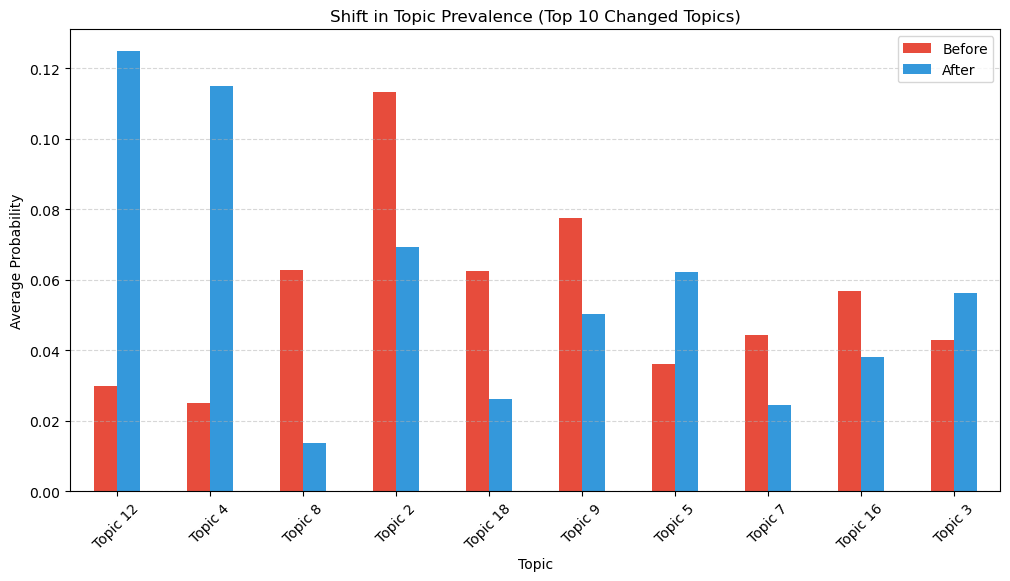

In [7]:
# Create masks for numpy slicing
is_before = np.array([p == 'Before' for p in periods])
is_after = np.array([p == 'After' for p in periods])

# Calculate mean probability for each topic in each period
topic_means_before = document_topics[:, is_before].mean(axis=1)
topic_means_after = document_topics[:, is_after].mean(axis=1)

# Prepare DataFrame for plotting
comparison_df = pd.DataFrame({
    'Topic': [f"Topic {i}" for i in range(TOPICS)],
    'Before': topic_means_before,
    'After': topic_means_after
})

# Sort by biggest difference (optional)
comparison_df['Diff'] = abs(comparison_df['After'] - comparison_df['Before'])
comparison_df = comparison_df.sort_values('Diff', ascending=False)

# Plot
comparison_df.head(10).plot(x='Topic', y=['Before', 'After'], kind='bar', figsize=(12, 6), color=['#E74C3C', '#3498DB'])
plt.title("Shift in Topic Prevalence (Top 10 Changed Topics)")
plt.ylabel("Average Probability")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Plotting individual trends for the first 3 topics...


NameError: name 'transition_date' is not defined

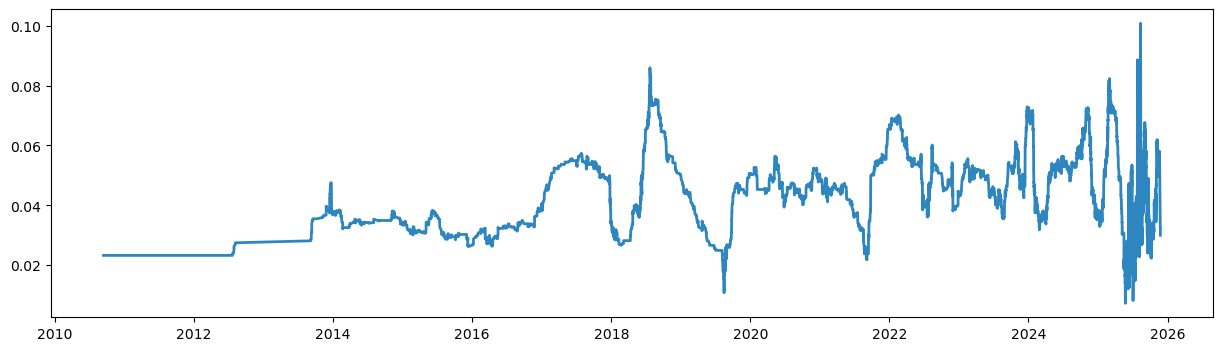

In [8]:
# --- 7. Individual Topic Graphs (Requested Extra View) ---

def moving_average_simple(X, bins):
    # Mode='same' ensures the output length aligns with the 'dates' array
    return np.convolve(X, np.ones(bins)/bins, mode='same')

print("Plotting individual trends for the first 3 topics...")

# Plot 3 separate graphs, one for each of the first 3 topics
for i in range(3):
    plt.figure(figsize=(15, 4))
    
    # Calculate smoothed trend
    y_smoothed = moving_average_simple(document_topics[i, :], WINDOW)
    
    # Plot
    plt.plot(dates, y_smoothed, label=f'Topic {i}', color='#2E86C1', linewidth=2)
    
    # Add Agent Introduction Line
    if transition_date:
        plt.axvline(transition_date, color='#C0392B', linestyle='--', linewidth=2, label='Agent Intro')
        
    plt.title(f"Topic {i} Prevalence Over Time")
    plt.xlabel("Date")
    plt.ylabel("Topic Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()